In [1]:
from ase import Atoms
from ase.io import read, write
import numpy as np
from ase import neighborlist
import re
import matplotlib.pyplot as plt
from math import exp
import os

from matplotlib.ticker import AutoMinorLocator

In [2]:
xtime=[]
yMSD=[]

In [3]:
# Calculate equilibrium vacancy concentration in pure Al

delta_Sv = 0.7 # Vibrational entropy change, in kB
delta_Ev = 0.67 # Enthalpy change, in eV
T = 25 # 300C
kB = 0.00008617333262145 # Boltzmann constant in eV

Cv_eq = np.exp(delta_Sv) * np.exp(-delta_Ev / (kB*(T + 273.15))) # Equilibrium vacancy concentration
Cv_eq

9.520546984006336e-12

In [4]:
# Calculate scaling factor for time

N = 12 # Dimension of box
Cv_box = 1 / (N**3 * 4)

SF = Cv_box / Cv_eq
SF

15196177.92643306

In [5]:
## get ALL OF THE DATA
cwd = os.getcwd()+'\\'+"1e-3 highthroughput"

for file in os.listdir(cwd): 
    ## read the dump file
    filename = cwd + "\\" + file + "\\" +'dump.diffCE'
    dump_read = read(filename, index=':')

    ## convert the label to real element number
    for Atoms in dump_read: 
        Atoms.pbc = [True, True, True]; 
        for atom in Atoms: 
            if atom.number == 2: 
                atom.number = 40
            if atom.number == 3: 
                atom.number = 50

    ## dump interval
    dump=[]
    for i in range(0,len(dump_read)):
        if i%1==0:
            dump.append(dump_read[i])

    ## read the KMC time 
    file = open(filename, 'r')
    Lines = file.readlines()
    KMC_time = np.zeros(len(dump_read))
    for i in range(0, len(Lines)): 
        if "ITEM: TIMESTEP" in Lines[i]:
            KMC_time[int(Lines[i+1].split()[0])] = Lines[i+1].split()[1]

    ## scale the time interval
    SF=1
    time_scaled=np.zeros(len(dump))
    j=0
    for i in range(0,len(KMC_time)):
        if i%1==0:
            time_scaled[j]=KMC_time[i]*SF
            j=j+1

    ## derive the displacement vector
    disp = np.zeros((len(dump),3))
    for i in range(1, len(dump)):
        temp = dump[i]
        for j in range(0, len(temp)):
            if temp[j].number == 0: 
                Va_index_this = j
        for j in range(0, len(temp)):
            if dump[i-1][j].number == 0: 
                Va_index_last = j
        temp.append(dump[i-1][Va_index_last])
        disp[i]=disp[i-1]+temp.get_distance(-1, Va_index_this, mic=True,vector=True)

    ## square displacements
    MSD = np.zeros(len(disp))
    for i in range(0, len(disp)): 
        MSD[i] = np.dot(disp[i],disp[i])

    xtime.append(time_scaled)
    yMSD.append(MSD)
    

In [6]:
# Create a continuous array
continuous_time = xtime[0]  # Start with the first array

for i in range(1, len(xtime)):
    # Calculate the offset for the current array
    offset = continuous_time[-1] - xtime[i][0]
    # Adjust the current array
    adjusted_array = xtime[i] + offset
    # Append to the continuous array
    continuous_time = np.concatenate((continuous_time, adjusted_array[1:]))

In [7]:
# Create a continuous array
continuous_MSD = yMSD[0]  # Start with the first array

for i in range(1, len(yMSD)):
    # Calculate the offset for the current array
    offset = continuous_MSD[-1] - yMSD[i][0]
    # Adjust the current array
    adjusted_array = yMSD[i] + offset
    # Append to the continuous array
    continuous_MSD = np.concatenate((continuous_MSD, adjusted_array[1:]))

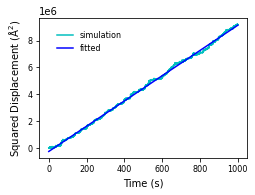

1.5676675868125335e-17

In [8]:
## plot all of the simulations

fig, ax = plt.subplots(figsize=(3.38583,2.53937))

ax.plot(continuous_time,continuous_MSD,'-', color='c',label='simulation')

a, b = np.polyfit(continuous_time, continuous_MSD, deg=1)
continuous_MSD_est = a*continuous_time + b

ax.plot(continuous_time, continuous_MSD_est, '-', linewidth=1.5,color='b',zorder=3,label='fitted')

#plt.title('Sn1Vac1 in 8x8x8 FCC unit cell')
plt.xlabel('Time (s)',fontsize=10)
plt.ylabel('Squared Displacement (Å$^2$)',fontsize=10)
#plt.title('Sn1Vac1 in 8x8x8 FCC unit cell')
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

ax.legend(loc='lower left', bbox_to_anchor=(0.05, 0.7),fontsize=8,frameon=False)

#ax.set_title('400 K', loc='left', y=0.80, x=0.80, fontsize=10)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.tight_layout(pad=0.1)  # otherwise the right y-label is slightly clipped

# plt.savefig('HTP-MSD.jpeg', dpi=1000)
plt.show()

D_Va = a*1E-20/6
D_Va

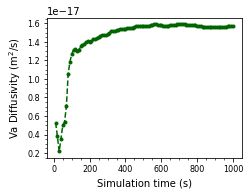

In [9]:
D_va_con=[]
t_con=[]
for i in range(10000,len(continuous_time),10000):
    fit_time=continuous_time[:i]
    fit_MSD=continuous_MSD[:i]
    a, b = np.polyfit(fit_time, fit_MSD, deg=1)
    fit_MSD_est = a*fit_time + b
    D_va_con.append(a*1E-20/6)
    # t_con.append(len(fit_time))
    t_con.append(continuous_time[i])

fig, ax = plt.subplots(figsize=(3.38583,2.53937))

ax.plot(t_con,D_va_con,'.--', linewidth=1.5,color='darkgreen')


#plt.title('Sn1Vac1 in 8x8x8 FCC unit cell')
plt.xlabel('Simulation time (s)',fontsize=10)
plt.ylabel('Va Diffusivity (m$^2$/s)',fontsize=10)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# ax.set_yscale('log')

#ax.set_title('100 times of KMC simulation', loc='left', y=0.85, x=0.05, fontsize='medium')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.tight_layout(pad=0.1)  # otherwise the right y-label is slightly clipped

plt.savefig('Diffusivity-VaVSCount-103-con.jpeg', dpi=1000)
plt.show()

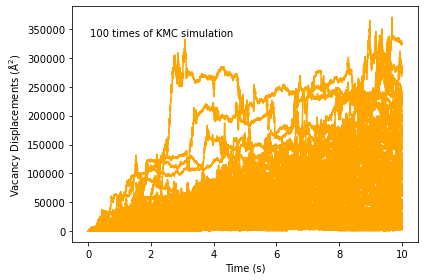

In [10]:
## plot all of the simulations

fig, ax = plt.subplots()

for i in range(0,len(yMSD)):
    ax.plot(xtime[i],yMSD[i],'-', color='orange')

#plt.title('Sn1Vac1 in 8x8x8 FCC unit cell')
plt.xlabel('Time (s)')
plt.ylabel('Vacancy Displacements (Å$^2$)')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax.set_title('100 times of KMC simulation', loc='left', y=0.85, x=0.05, fontsize='medium')

# plt.savefig('HTP-MSD.jpeg', dpi=1000)
plt.show()


In [11]:
number=10000
index_number=0

for i in range(0,len(yMSD)):
    number=min(number,len(yMSD[i]))

number

10000

In [12]:
time1=np.arange(number)
time1[5]

5

In [13]:
yMSD_ave=np.zeros(number)

for i in range(0,number):
    SUM=0.0
    for j in range(0,len(yMSD)):
        SUM+=yMSD[j][i]
    yMSD_ave[i]=SUM/len(yMSD)


In [14]:
yMSD_ave[number-1]

91734.41028800003

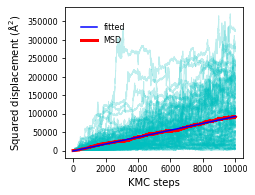

In [15]:
## plot mean square displcement

time = xtime[0]
#plt.scatter(time, MSD)

a, b = np.polyfit(time1, yMSD_ave, deg=1)
MSD_est = a*time1 + b
#MSD_err = time.std() * np.sqrt(1/len(time) + (time - time.mean())**2 / np.sum((time - time.mean())**2))

fig, ax = plt.subplots(figsize=(3.38583,2.53937))
ax.plot(time1, MSD_est, '-', linewidth=1.5,color='b',zorder=3,label='fitted')
#ax.fill_between(time, MSD_est - MSD_err, MSD_est + MSD_err, alpha=0.2)
ax.plot(time1, yMSD_ave, '-', linewidth=3,color='r',zorder=2,label='MSD')

for i in range(0,len(yMSD)):
    ax.plot(np.arange(len(xtime[i])),yMSD[i],'-',color='c', linewidth=1,alpha=0.25,zorder=1)


#plt.title('Sn1Vac1 in 8x8x8 FCC unit cell')
plt.xlabel('KMC steps',fontsize=10)
plt.ylabel('Squared displacement (Å$^2$)',fontsize=10)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

ax.legend(loc='lower left', bbox_to_anchor=(0.05, 0.7),fontsize=8,frameon=False)

#ax.set_title('400 K', loc='left', y=0.80, x=0.80, fontsize=10)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.tight_layout(pad=0.1)  # otherwise the right y-label is slightly clipped
plt.show()

D_Va = a*1E-20/6

In [16]:
D_Va/1e-3

1.5579865600784677e-17

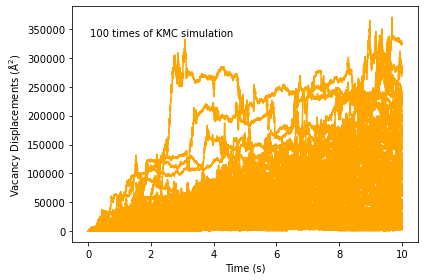

In [17]:
## plot all of the simulations
D_Va=[]

fig, ax = plt.subplots()

for i in range(0,len(yMSD)):
    ax.plot(xtime[i],yMSD[i],'-', color='orange')

    a, b = np.polyfit(xtime[i], yMSD[i], deg=1)
    MSD_est = a*xtime[i] + b
    D_Va.append(a*1E-20/6)

#plt.title('Sn1Vac1 in 8x8x8 FCC unit cell')
plt.xlabel('Time (s)')
plt.ylabel('Vacancy Displacements (Å$^2$)')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax.set_title('100 times of KMC simulation', loc='left', y=0.85, x=0.05, fontsize='medium')

#plt.savefig('HTP-MSD.jpeg', dpi=1000)
plt.show()


In [18]:
n=np.arange(1,len(D_Va)+1)
n

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [19]:
D_Va_ave=[]

for i in n:
    D_Va_ave.append(sum(D_Va[0:i])/i)

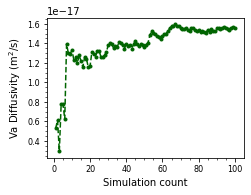

In [20]:
fig, ax = plt.subplots(figsize=(3.38583,2.53937))

ax.plot(n,D_Va_ave,'.--', linewidth=1.5,color='darkgreen')


#plt.title('Sn1Vac1 in 8x8x8 FCC unit cell')
plt.xlabel('Simulation count',fontsize=10)
plt.ylabel('Va Diffusivity (m$^2$/s)',fontsize=10)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# ax.set_yscale('log')

#ax.set_title('100 times of KMC simulation', loc='left', y=0.85, x=0.05, fontsize='medium')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.tight_layout(pad=0.1)  # otherwise the right y-label is slightly clipped

plt.savefig('Diffusivity-VaVSCount-103.jpeg', dpi=1000)
plt.show()